# Exploring copy number variation (CNV)

In this notebook we will explore copy number variation (CNV) within the Ag1000G phase 3 samples, focusing on some specific genome regions of interest. We will use the copy number state data for each individual sample, inferred from fitting an HMM to windowed coverage data, to visualise evidence for copy number variation. We will also estimate the frequency of copy number variation in different genes and populations.

As usual this notebook is executable, click the launch icon above (<i class="fas fa-rocket"></i>) to run it for yourself. Note in particular that, although this notebook investigates the *Cyp9k1* and *Cyp6p/aa* genome regions as examples, if you run this notebook yourself you can change this to investigate any genome region you are interested in.

## Setup

Install the packages we'll need. If you're working on MyBinder, you can skip this step, packages are already installed.

In [2]:
!pip install -qU malariagen_data bokeh

Import packages.

In [3]:
import malariagen_data
from bisect import bisect_left, bisect_right
import numpy as np
import dask.array as da
from dask.diagnostics import ProgressBar
import bokeh.io as bkio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook we'll be making some interactive plots using the [bokeh](https://docs.bokeh.org/en/latest/index.html) package. Set up plotting with bokeh in the notebook.

In [4]:
bkio.output_notebook()

Finally, setup access to `Ag3` data in Google Cloud.

In [5]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 data resource API>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0
Cohorts analysis        : 20211101
Species analysis        : aim_20200422
Site filters analysis   : dt_20200416
Software version        : 3.0.0
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see: 
https://malariagen.github.io/vector-data/ag3/api.html

## Introduction to copy number variation

Mosquitoes are diploid organisms, like us, meaning that each individual mosquito inherits two complete genome copies, one from each parent. Thus, for any given gene within the mosquito genome sequence, an individual will normally carry two copies.

Of course, genomes can vary. One common type of genome variation is single nucleotide polymorphism (SNP), which we've previously explored in the analysis notebooks on [SNPs](snps) and [SNP effects](snp-effects). Another way that genomes can vary is where a gene, or a genome region containing multiple genes, becomes copied two or more times within the same chromosome. Genes or genome regions can also sometimes be deleted. This is known as [copy number variation (CNV)](https://www.genome.gov/genetics-glossary/Copy-Number-Variation). 

Previously, the Ag1000G Consortium analysed copy number variation within the Ag1000G phase 2 data resource ([Lucas et al. 2019](https://genome.cshlp.org/content/29/8/1250.full)). A key finding was that, although CNVs can occur throughout the mosquito genome, there are several genome hotspots where CNVs occur much more frequently. Several of these hotspots occur in genome regions containing genes involved in metabolic resistance to insecticides, such as cytochrome P450 and glutathione S-transferase genes. It has been known for several decades that copy number variation within these gene families likely plays an important role in insecticide resistance. More copies of a gene means more of the corresponding protein will be expressed, and increasing expression of genes that can metabolise insecticides leads to increased ability to tolerate the insecticide ([Adolfi et al. 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6926047/)).

For the Ag1000G phase 3 data resource, we have estimated the copy number state for each individual mosquito throughout the entire genome sequence, compared to the AgamP4 reference sequence. For each mosquito we've counted the number of aligned sequence reads within fixed-size 300 bp windows, then normalised this coverage data and fitted a hidden Markov model. Further details are given in the section on CNV calling in the [methods page](../methods). 

The results of these CNV HMMs provide a rich dataset for exploring copy number variation in any given genome region of interest.

## Accessing CNV HMM data

The CNV HMM results for a given chromosome and given sample sets can be accessed using the `cnv_hmm` method. Let's access the data for chromosome arm 2R, for two of the `Ag3` sample sets from Burkina Faso.

In [6]:
ds_hmm = ag3.cnv_hmm(region="2R", sample_sets=["AG1000G-BF-A", "AG1000G-BF-B"])
ds_hmm

<xarray.Dataset>
Dimensions:                   (samples: 283, variants: 205151)
Coordinates:
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(205151,), meta=np.ndarray>
    sample_id                 (samples) object dask.array<chunksize=(181,), meta=np.ndarray>
Dimensions without coordinates: samples, variants
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 64), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 64), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 64), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(181,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(181,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

The `ds_hmm` variable is an [xarray dataset](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset). This is simply a container for several data arrays. In particular, we'll be most interested in the `variant_position` and `variant_end` arrays, which provide the genomic coordinates for the window start and stop positions; and the `call_CN` array, which provides the inferred copy number state across samples and windows. Let's look at each of these in turn.

In [7]:
# window start coordinates (1-based)
ds_hmm['variant_position'].values

array([       1,      301,      601, ..., 61544401, 61544701, 61545001],
      dtype=int32)

In [8]:
# window end coordinates (1-based, inclusive)
ds_hmm['variant_end'].values

array([     300,      600,      900, ..., 61544700, 61545000, 61545105],
      dtype=int32)

In [9]:
# copy number state predictions from the HMMs
ds_hmm['call_CN']

<xarray.DataArray 'call_CN' (variants: 205151, samples: 283)>
dask.array<concatenate, shape=(205151, 283), dtype=int8, chunksize=(65536, 64), chunktype=numpy.ndarray>
Coordinates:
    variant_position  (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_end       (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig    (variants) uint8 dask.array<chunksize=(205151,), meta=np.ndarray>
    sample_id         (samples) object dask.array<chunksize=(181,), meta=np.ndarray>
Dimensions without coordinates: variants, samples

Notice that the `call_CN` array has 205,151 rows and 283 columns. That's because there are 205,151 windows on chromosome arm 2R, and we've requested data for 283 individual mosquitoes. For example, here are the copy number state predictions for the first 5 genome windows, for the first sample:

In [10]:
cn = ds_hmm['call_CN'].values
cn[:5, 0]

array([7, 4, 4, 8, 8], dtype=int8)

The numbers 7, 4, 4, 8 and 8 are copy number states. Above I said that the normal copy number state is 2, so what's going on here? Well, these values are from the beginning of the chromosome arm, and the ends of the chromosome can exhibit a lot of copy number variation. Let's gain some more intuition by making a histogram of the `call_CN` values across all windows and individuals.

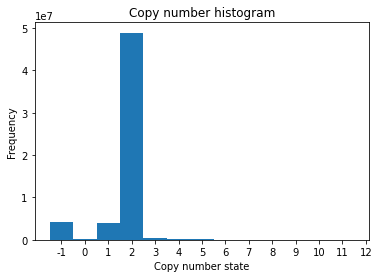

In [11]:
fig, ax = plt.subplots()
ax.hist(cn.flatten(), bins=np.arange(-1, 13, 1))
ax.set_xlabel('Copy number state')
ax.set_ylabel('Frequency')
ax.set_title('Copy number histogram')
ax.set_xticks(np.arange(-1, 13, 1) + .5)
ax.set_xticklabels(np.arange(-1, 13, 1));

Above we can see that by far the most common copy number state is 2, as expected. A copy number state less than 2 implies a deletion relative to the reference genome. A copy number state greater than 2 implies an amplification relative to the reference genome. The special value -1 means that the copy number state could not be inferred because of unreliable sequence read alignments.

OK, now we have some sense of what the data look like, let's explore some specific genome regions of interest.

## Visualising amplifications and deletions 

There are a number of ways of plotting the results of the CNV HMMs in order to visually search for the presence or absence of CNVs in a genome region of interest, and explore their locations and frequencies in different populations. 

### *Cyp9k1* region

In our previous analysis of Ag1000G phase 2, we found that the region surrounding the *Cyp9k1* gene on the X chromosome was a CNV hotspot. Let's explore that in the `Ag3` data resource.

In [16]:
ag3.plot_cnv_hmm_heatmap(
    region="X:15,233,000-15,260,000", 
    sample_sets=["AG1000G-BF-A", "AG1000G-BF-B"], 
    sample_query="taxon == 'gambiae' and sex_call == 'F'"
);

In the above plots, we can see that many of the *An. gambiae* individuals have a copy number amplification spanning the *Cyp9k1* gene.

Let's compare with the *An. coluzzii*.

In [17]:
ag3.plot_cnv_hmm_heatmap(
    region="X:15,233,000-15,260,000", 
    sample_sets=["AG1000G-BF-A", "AG1000G-BF-B"], 
    sample_query="taxon == 'coluzzii' and sex_call == 'F'"
);

Apparently, amplifications spanning *Cyp9k1* in the *An. coluzzii* in these sample sets are much less common.

### *Cyp6p/aa* region

For comparison, let's also visualise CNVs in the *Cyp6p/aa* region on chromosome arm 2R, another known CNV hotspot.

In [23]:
ag3.plot_cnv_hmm_heatmap(
    region="2R:28,450,000-28,580,000", 
    sample_sets=["AG1000G-BF-A", "AG1000G-BF-B"], 
    sample_query="taxon == 'gambiae'"
);

Again, let's compare with the *An. coluzzii* from the same sample sets.

In [25]:
ag3.plot_cnv_hmm_heatmap(
    region="2R:28,450,000-28,580,000", 
    sample_sets=["AG1000G-BF-A", "AG1000G-BF-B"], 
    sample_query="taxon == 'coluzzii'"
);

In this genome region, amplifications appear to be much more common among the *An. coluzzii* in these sample sets than the *An. gambiae*. This is an indication that, within Burkina Faso, different cytochrome P450 genes may be playing a role in pyrethroid insecticide resistance in different species.

## Summarising CNV frequencies by gene

In addition to visualising the data, it can also be useful to summarise the HMM results by gene. In this case, we might use the modal copy number state within the windows spanning a gene to estimate the gene copy number within an individual mosquito. The `gene_cnv_frequencies` method provides an implementation of this.

Let's illustrate this by computing CNV frequencies for the genes in the *Cyp6p/aa* cluster, again using two Burkina Faso sample sets. These two sample sets provide data from two different species and time points, which can be intersting to compare.

Compute CNV frequencies in genes in the *Cyp6aa/p* cluster.

In [26]:
df_cnv_cyp6aap = ag3.gene_cnv_frequencies(
    region="2R:28,450,000-28,510,000", 
    cohorts="admin1_year", 
    sample_sets=["AG1000G-BF-A", "AG1000G-BF-B"]
)
df_cnv_cyp6aap

gene_strand  \
gene_id    gene_name cnv_type               
AGAP002862 CYP6AA1   amp                -   
AGAP013128 CYP6AA2   amp                -   
AGAP002863 COEAE6O   amp                -   
AGAP002864 CYP6P15P  amp                -   
AGAP002865 CYP6P3    amp                -   
                     del                -   
AGAP002866 CYP6P5    amp                -   
AGAP002867 CYP6P4    amp                -   
AGAP002868 CYP6P1    amp                -   
AGAP002869 CYP6P2    amp                -   
AGAP002870 CYP6AD1   amp                -   

                                                                gene_description  \
gene_id    gene_name cnv_type                                                      
AGAP002862 CYP6AA1   amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP013128 CYP6AA2   amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP002863 COEAE6O   amp       carboxylesterase alpha esterase [Source:VB Com...   
AGAP002864 CYP6P15P  amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP002865 CYP6P3    amp        cytochrome P450 [Source:VB Community Annotation]   
                     del        cytochrome P450 [Source:VB Community Annotation]   
AGAP002866 CYP6P5    amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP002867 CYP6P4    amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP002868 CYP6P1    amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP002869 CYP6P2    amp        cytochrome P450 [Source:VB Community Annotation]   
AGAP002870 CYP6AD1   amp        cytochrome P450 [Source:VB Community Annotation]   

                              contig     start       end  frq_BF-09_colu_2012  \
gene_id    gene_name cnv_type                                                   
AGAP002862 CYP6AA1   amp          2R  28480576  28482637               0.9125   
AGAP013128 CYP6AA2   amp          2R  28483301  28484921               0.8250   
AGAP002863 COEAE6O   amp          2R  28485262  28487080               0.6000   
AGAP002864 CYP6P15P  amp          2R  28487640  28489092               0.5250   
AGAP002865 CYP6P3    amp          2R  28491415  28493141               0.0375   
                     del          2R  28491415  28493141               0.0000   
AGAP002866 CYP6P5    amp          2R  28494017  28495645               0.0375   
AGAP002867 CYP6P4    amp          2R  28497087  28498674               0.0375   
AGAP002868 CYP6P1    amp          2R  28499251  28500900               0.0375   
AGAP002869 CYP6P2    amp          2R  28501033  28502910               0.0375   
AGAP002870 CYP6AD1   amp          2R  28504248  28505816               0.0375   

                               frq_BF-09_colu_2014  frq_BF-09_gamb_2012  \
gene_id    gene_name cnv_type                                             
AGAP002862 CYP6AA1   amp                  0.811321             0.041237   
AGAP013128 CYP6AA2   amp                  0.792453             0.041237   
AGAP002863 COEAE6O   amp                  0.509434             0.010309   
AGAP002864 CYP6P15P  amp                  0.528302             0.010309   
AGAP002865 CYP6P3    amp                  0.075472             0.010309   
                     del                  0.000000             0.113402   
AGAP002866 CYP6P5    amp                  0.056604             0.020619   
AGAP002867 CYP6P4    amp                  0.075472             0.010309   
AGAP002868 CYP6P1    amp                  0.056604             0.010309   
AGAP002869 CYP6P2    amp                  0.056604             0.010309   
AGAP002870 CYP6AD1   amp                  0.056604             0.010309   

                               frq_BF-09_gamb_2014    max_af  windows  \
gene_id    gene_name cnv_type                                           
AGAP002862 CYP6AA1   amp                  0.065217  0.912500        8   
AGAP013128 CYP6AA2   amp                  0.065217  0.825000        6   
AGAP002863 COEAE6O   amp     

Finally, let's make this table a little more readable by removing some columns and highlighting frequencies.

In [27]:
ag3.plot_frequencies_heatmap(df_cnv_cyp6aap)

Here we can see that the most commonly amplified gene is *Cyp6aa1*, which is amplified in 90% of *An. coluzzii* individuals in 2012 and 81% of *An. coluzzii* individuals in 2014.

## Further reading

Hopefully this notebook has been a useful introduction to exploring CNVs in the `Ag3` data resource. Don't forget you can use this notebook to analyse any genome region of interest. If you have any comments, questions or suggestions, please feel free to [get in touch](https://github.com/malariagen/vector-data/discussions). 

This notebook is part of the [Ag1000G phase 3 user guide](../intro). See the menu at the left for more documentation and example analyses.

If you're interested to read more about CNVs in general and in *Anopheles* mosquitoes, check out the following links:

* [Copy number variation (CNV) glossary entry at genome.gov](https://www.genome.gov/genetics-glossary/Copy-Number-Variation)
* [Copy number variation on Wikipedia](https://en.wikipedia.org/wiki/Copy_number_variation)
* [Lucas et al. (2019)](https://genome.cshlp.org/content/29/8/1250.full) Whole-genome sequencing reveals high complexity of copy number variation at insecticide resistance loci in malaria mosquitoes
* [Adolfi et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6926047/) Functional genetic validation of key genes conferring insecticide resistance in the major African malaria vector, Anopheles gambiae